In [141]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
import random
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.cluster import KMeans

In [142]:
IS_PARAMETER_TUNING_ENABLED = False

## Data Exploration and Preprocessing

1. Loading and Exploring the Dataset

In [143]:
df = pd.read_csv('./diamonds.csv')

df.info()
df.describe()
df.head()
df.drop(df.columns[0], axis=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


2. Handling Missing Values

In [144]:
# check if has null values in dataset
print(df.isnull().sum())

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64


3. Categorical to Numerical Conversion

In [145]:
# use one-hot encoding
data_encoded = pd.get_dummies(df, columns=['cut', 'color', 'clarity'], drop_first=True)

4. Target Feature

In [146]:
y = data_encoded['price']

5. Data Visualization

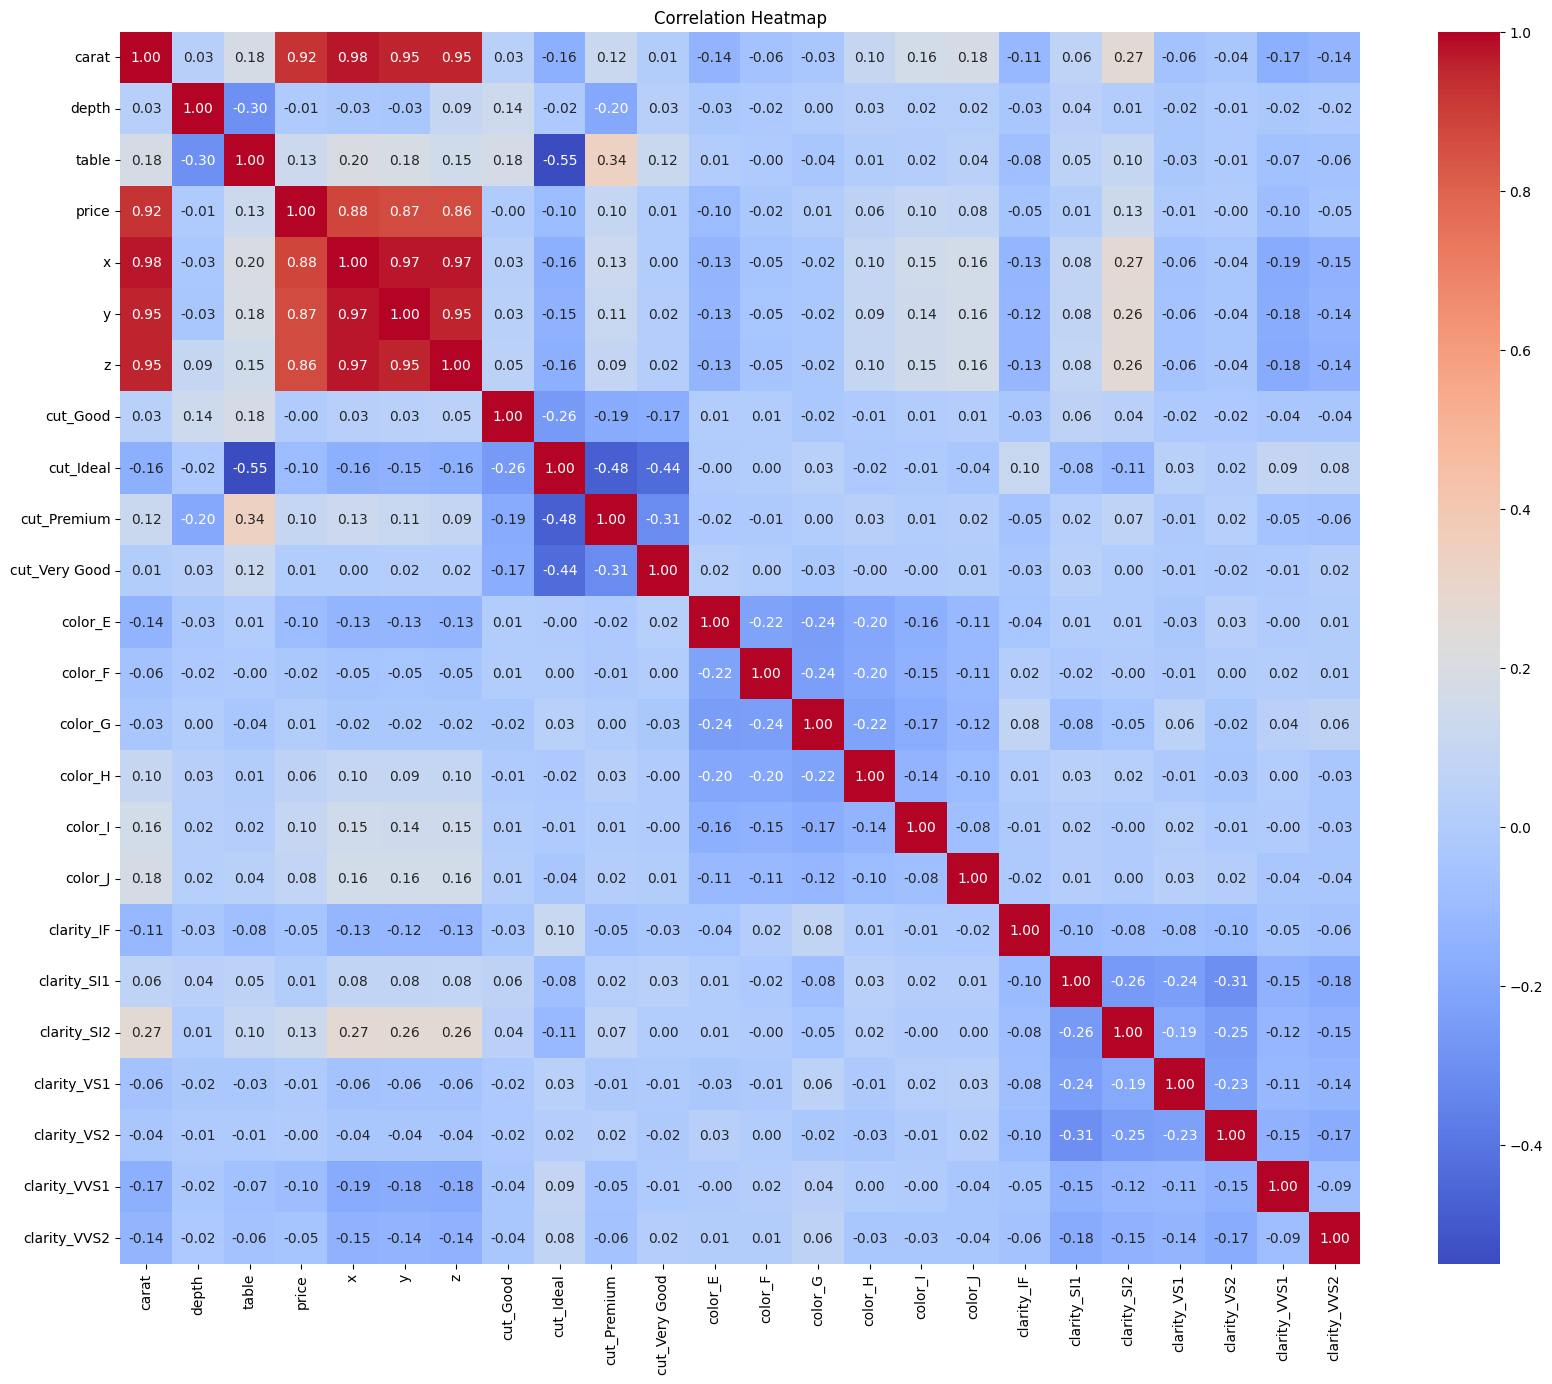

carat            0.921591
x                0.884435
y                0.865421
z                0.861249
clarity_SI2      0.128420
table            0.127134
color_I          0.097125
cut_Premium      0.095706
color_J          0.081710
color_H          0.059223
clarity_SI1      0.008957
color_G          0.008556
cut_Very Good    0.006593
cut_Good        -0.000312
clarity_VS2     -0.001062
clarity_VS1     -0.009886
depth           -0.010647
color_F         -0.024161
clarity_IF      -0.049596
clarity_VVS2    -0.052381
clarity_VVS1    -0.095266
cut_Ideal       -0.097175
color_E         -0.101089
Name: price, dtype: float64


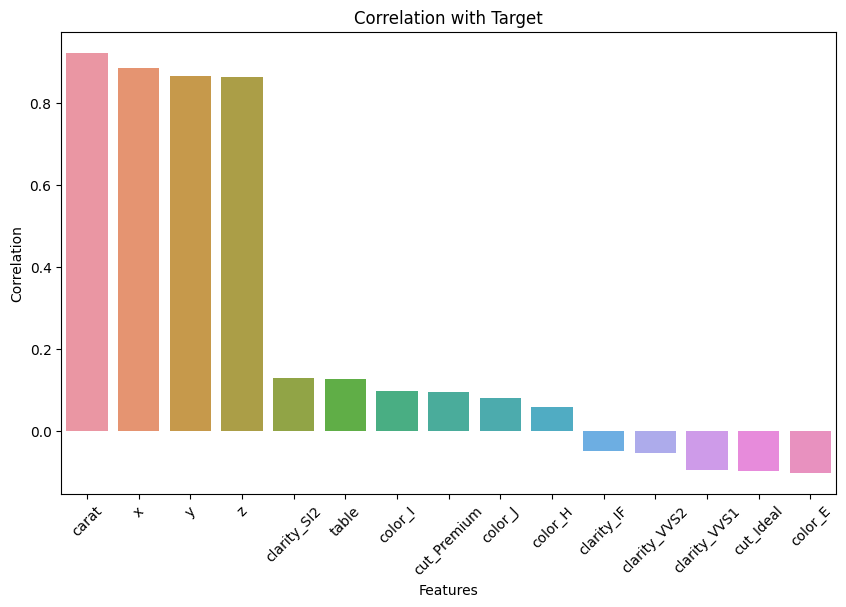

Selected Features:
carat           0.921591
x               0.884435
y               0.865421
z               0.861249
clarity_SI2     0.128420
table           0.127134
color_I         0.097125
cut_Premium     0.095706
color_J         0.081710
color_H         0.059223
clarity_IF     -0.049596
clarity_VVS2   -0.052381
clarity_VVS1   -0.095266
cut_Ideal      -0.097175
color_E        -0.101089
Name: price, dtype: float64


In [147]:
correlations = data_encoded.corr()

correlation_with_target = correlations['price'].sort_values(ascending=False)[1:]

plt.figure(figsize=(20, 16))
sns.heatmap(correlations, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

print(correlation_with_target)

correlation_threshold = 0.04
selected_features = correlation_with_target[abs(correlation_with_target) > correlation_threshold]

# plot correlation values for selected features
plt.figure(figsize=(10, 6))
sns.barplot(x=selected_features.index, y=selected_features)
plt.xticks(rotation=45)
plt.title('Correlation with Target')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.show()

print("Selected Features:")
print(selected_features)

6. Data Splitting for Model Training

In [148]:
X = data_encoded[selected_features.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_nn_test, y_val, y_nn_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_nn_test_scaled = scaler.transform(X_nn_test)
X_test_scaled = scaler.transform(X_test)

In [149]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    train_predictions = model.predict(X_train)

    train_mae = mean_absolute_error(y_train, train_predictions)
    train_r2 = r2_score(y_train, train_predictions)

    test_predictions = model.predict(X_test)

    test_mae = mean_absolute_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)

    print(f"Training Mean Absolute Error: {train_mae}")
    print(f"Training R2 Score: {train_r2}")
    print(f"Test Mean Absolute Error: {test_mae}")
    print(f"Test R2 Score: {test_r2}")
    return test_predictions

# create a plot to visualize predicted prices vs. actual prices in the test set
def visualize_predictions(y_test, test_predictions, plot_title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, test_predictions, alpha=0.5)
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title(plot_title)
    plt.show()

## Learning Models

1. Linear Regression

Training Mean Absolute Error: 798.0417835462746
Training R2 Score: 0.896492101570519
Test Mean Absolute Error: 787.5344550533167
Test R2 Score: 0.897881238730942


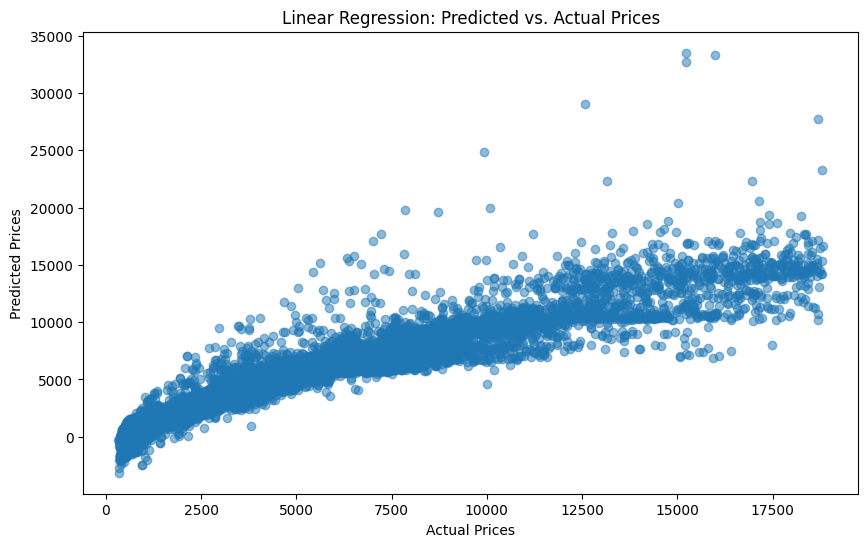

In [150]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

test_predictions = evaluate_model(lr_model, X_train, X_test, y_train, y_test)
visualize_predictions(y_test, test_predictions, 'Linear Regression: Predicted vs. Actual Prices')

2. Neural Network

Epoch 1/100
1180/1180 [==============================] - 3s 2ms/step - loss: 3583800.5000 - val_loss: 1154176.3750
Epoch 2/100
1180/1180 [==============================] - 2s 2ms/step - loss: 2377992.7500 - val_loss: 1049327.8750
Epoch 3/100
1180/1180 [==============================] - 2s 2ms/step - loss: 2101480.2500 - val_loss: 1039817.3125
Epoch 4/100
1180/1180 [==============================] - 2s 2ms/step - loss: 1976180.1250 - val_loss: 1009775.0625
Epoch 5/100
1180/1180 [==============================] - 2s 2ms/step - loss: 2036393.8750 - val_loss: 975436.7500
Epoch 6/100
1180/1180 [==============================] - 2s 2ms/step - loss: 1946048.2500 - val_loss: 975852.6250
Epoch 7/100
1180/1180 [==============================] - 2s 2ms/step - loss: 1827392.0000 - val_loss: 1482694.1250
Epoch 8/100
1180/1180 [==============================] - 2s 2ms/step - loss: 1806842.2500 - val_loss: 1574985.6250
Epoch 9/100
1180/1180 [==============================] - 2s 2ms/step - loss: 18347

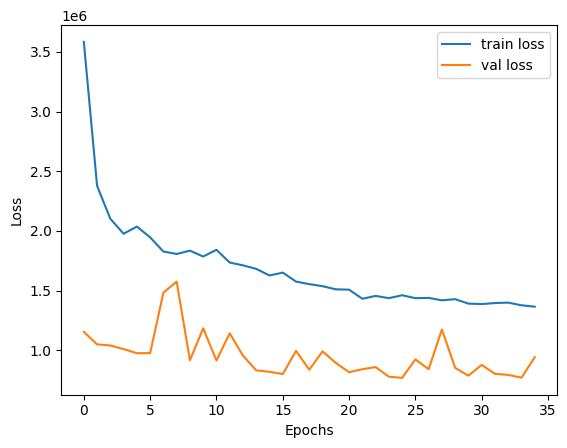

253/253 [==============================] - 0s 583us/step
Training Mean Absolute Error: 499.35792805556366
Training R2 Score: 0.9491926517605402
Test Mean Absolute Error: 501.63449778242705
Test R2 Score: 0.9501040107387674


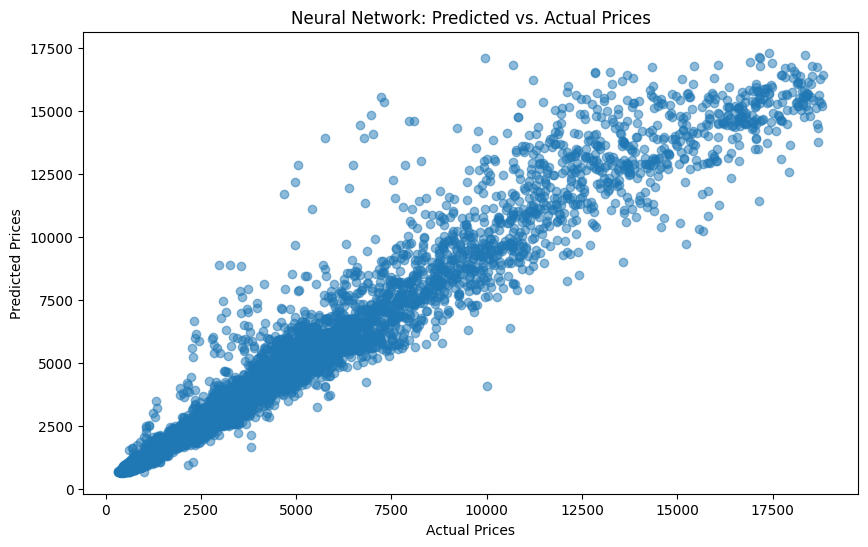

In [170]:
nn_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

nn_model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = nn_model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=100, batch_size=32, callbacks=[early_stopping])

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

test_predictions = evaluate_model(nn_model, X_train_scaled, X_nn_test_scaled, y_train, y_nn_test)
visualize_predictions(y_nn_test, test_predictions, 'Neural Network: Predicted vs. Actual Prices')

3. Random Forest

Training Mean Absolute Error: 162.07928174111842
Training R2 Score: 0.9934672192998247
Test Mean Absolute Error: 431.38594919871036
Test R2 Score: 0.9536305276503081


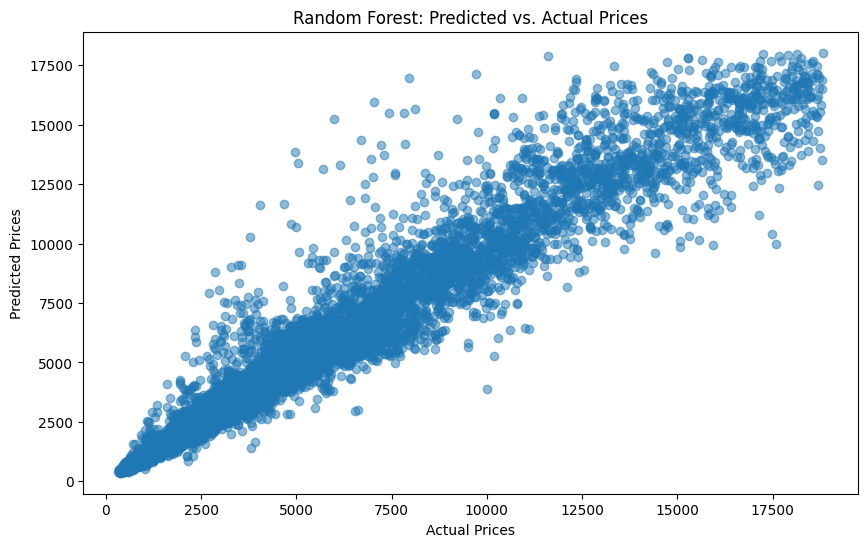

In [152]:
rf_model = RandomForestRegressor(n_estimators=400, random_state=42)
rf_model.fit(X_train, y_train)

test_predictions = evaluate_model(rf_model, X_train, X_test, y_train, y_test)
visualize_predictions(y_test, test_predictions, 'Random Forest: Predicted vs. Actual Prices')

## Parameter Tuning

1. Neural Network

In [153]:
if IS_PARAMETER_TUNING_ENABLED:

    def create_model(hidden_layers=1, units=64, kernel_initializer='glorot_uniform', activation='relu'):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)))
        for _ in range(hidden_layers):
            model.add(tf.keras.layers.Dense(units, kernel_initializer=kernel_initializer, activation=activation))
            model.add(tf.keras.layers.Dropout(0.2))
        model.add(tf.keras.layers.Dense(1))
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model
    
    keras_regressor = KerasRegressor(model=create_model, verbose=0, hidden_layers=1, units=64, kernel_initializer='glorot_uniform', activation='relu')
    
    param_grid = {
        'hidden_layers': [1, 2, 3, 4, 5, 6, 7],
        'units': [32, 64, 128],
        'kernel_initializer': ['glorot_uniform', 'he_normal'],
        'activation': ['relu', 'tanh']
    }
    
    
    grid = GridSearchCV(estimator=keras_regressor, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
    
    grid_result = grid.fit(X_train_scaled, y_train)
    
    print("Best Parameters: ", grid_result.best_params_)
    print("Best Validation Score: ", grid_result.best_score_)

2. Random Forest

In [154]:
if IS_PARAMETER_TUNING_ENABLED:

    param_grid = {
        'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400]
    }
    
    rf_regressor = RandomForestRegressor(random_state=42)
    
    grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
    
    grid_search.fit(X_train, y_train)
    
    best_n_estimators = grid_search.best_params_['n_estimators']
    
    best_rf_model = RandomForestRegressor(n_estimators=best_n_estimators, random_state=42)
    
    best_rf_model.fit(X_train, y_train)
    
    test_predictions = best_rf_model.predict(X_test)
    
    test_mae = mean_absolute_error(y_test, test_predictions)
    
    print("Best Number of Estimators:", best_n_estimators)
    print("Test Mean Absolute Error:", test_mae)

## Clustering

1. Choose best K using elbow method

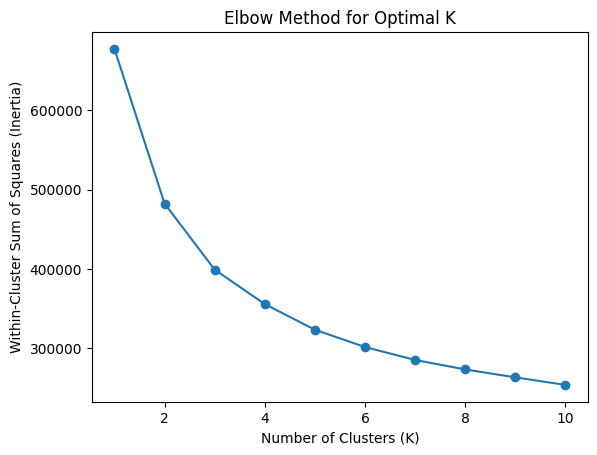

In [155]:
X = data_encoded.drop(columns=['price'])

inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (Inertia)')
plt.title('Elbow Method for Optimal K')
plt.show()

2. Develop model

cluster
0    3014.592758
1    5304.379334
Name: price, dtype: float64


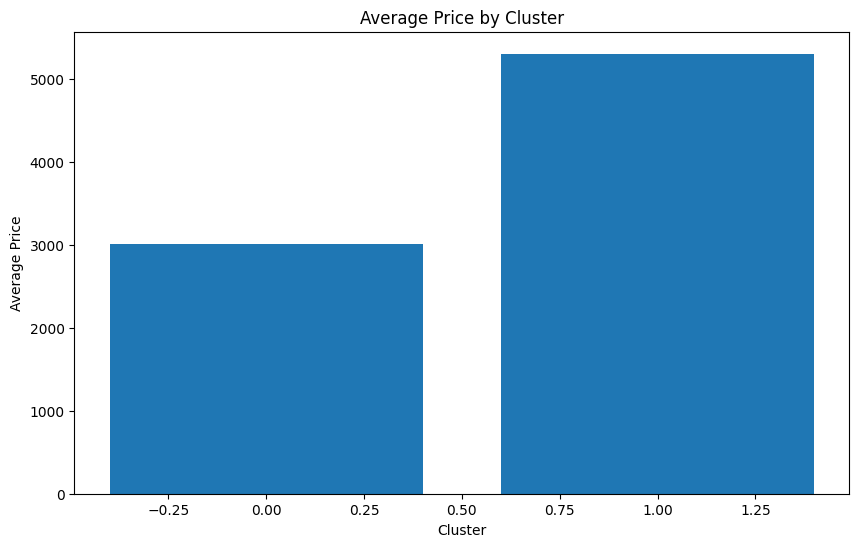

In [156]:
K = 2 # best K
kmeans = KMeans(n_clusters=K, random_state=42)

kmeans.fit(X)

# add the cluster labels to the dataset
data_copy = df.copy(deep=True)
data_copy['cluster'] = kmeans.labels_

# analyze the relationship between clusters and prices
cluster_prices = data_copy.groupby('cluster')['price'].mean()
print(cluster_prices)

plt.figure(figsize=(10, 6))
plt.bar(cluster_prices.index, cluster_prices.values)
plt.xlabel('Cluster')
plt.ylabel('Average Price')
plt.title('Average Price by Cluster')
plt.show()

## Results Analysis

In [166]:
random_indices = random.sample(range(X_test.shape[0]), 3)
random_instances = X_test.iloc[random_indices]
actual_labels = y_test.iloc[random_indices]

lr_predictions = lr_model.predict(random_instances)
rf_predictions = rf_model.predict(random_instances)
nn_predictions = nn_model.predict(X_test_scaled[random_indices])

lr_r2_score = r2_score(actual_labels, lr_predictions.round())
rf_r2_score = r2_score(actual_labels, rf_predictions.round())
nn_r2_score = r2_score(actual_labels, nn_predictions.round())


print("Linear Regression R2 score:", lr_r2_score)
print("Random Forest R2 score:", rf_r2_score)
print("Neural Network R2 score:", nn_r2_score)

1/1 [==============================] - 0s 13ms/step
Linear Regression R2 score: 0.8430201046675991
Random Forest R2 score: 0.9863302849449765
Neural Network R2 score: 0.9463480252560946
